In [1]:
# ! pip install hyperopt

In [2]:
from ricatti_observer_class import riccati_observer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
riccati_obj = riccati_observer(
    use_adaptive            = True,
    quaternion              = True,
    time                    = (0, 2),
    stepsize                = 0.1,
    tol                     = 1e-2 * 3,
    noise                   = False,
    which_eq                = 0,
    which_omega             = "full",
    with_image_hz_sim       = True,
    image_hz                = 60, 
    randomize_image_input   = False,
    p_hat                   = np.array([[-2, 4, 3]], dtype=np.float64).T,
    Lambda_bar_0            = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0,  0]).T,  # quaternion: w, x, y, z
    z_appear                = np.array([[[2.5, 2.5, 0]], [[5, 0, 0]], [[0, 0, 0]]]),
    k                       = 1,
    q                       = [10], 
    v                       = np.array([0.1, 1]),
    p_ricatti               = np.array([1, 100])
    )


        Parameters
        use_adaptive           | True
        quaternion             | True
        time                   | (0, 2)
        stepsize               | 0.1
        tol                    | 0.03
        noise                  | False
        which_eq               | 0
        which_omega            | full
        with_image_hz_sim      | True
        image_hz               | 60
        randomize_image_input  | False
        number of landmark     | 3
        Initial estimate pose  | [-2.  4.  3.]
        Initial estimate ori   | [0.70710678 0.70710678 0.         0.        ]
        k                      | 1
        z_appear               | [2.5 2.5 0.  5.  0.  0.  0.  0.  0. ]
        Q                      |
                                 10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                             0.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                             0.0  0.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0   
                             

In [4]:
riccati_obj.main()

/home/annika/ITRL/kth_thesis/ricatti_observer_class.py:576: RuntimeWarning: divide by zero encountered in double_scalars
  dt = dt * min(max_scale_factor, max(min_scale_factor, safety_factor * (tol / error_norm)**0.25))


Simulation time: 1.9999893648715585     Run time: 2.04241132736206055



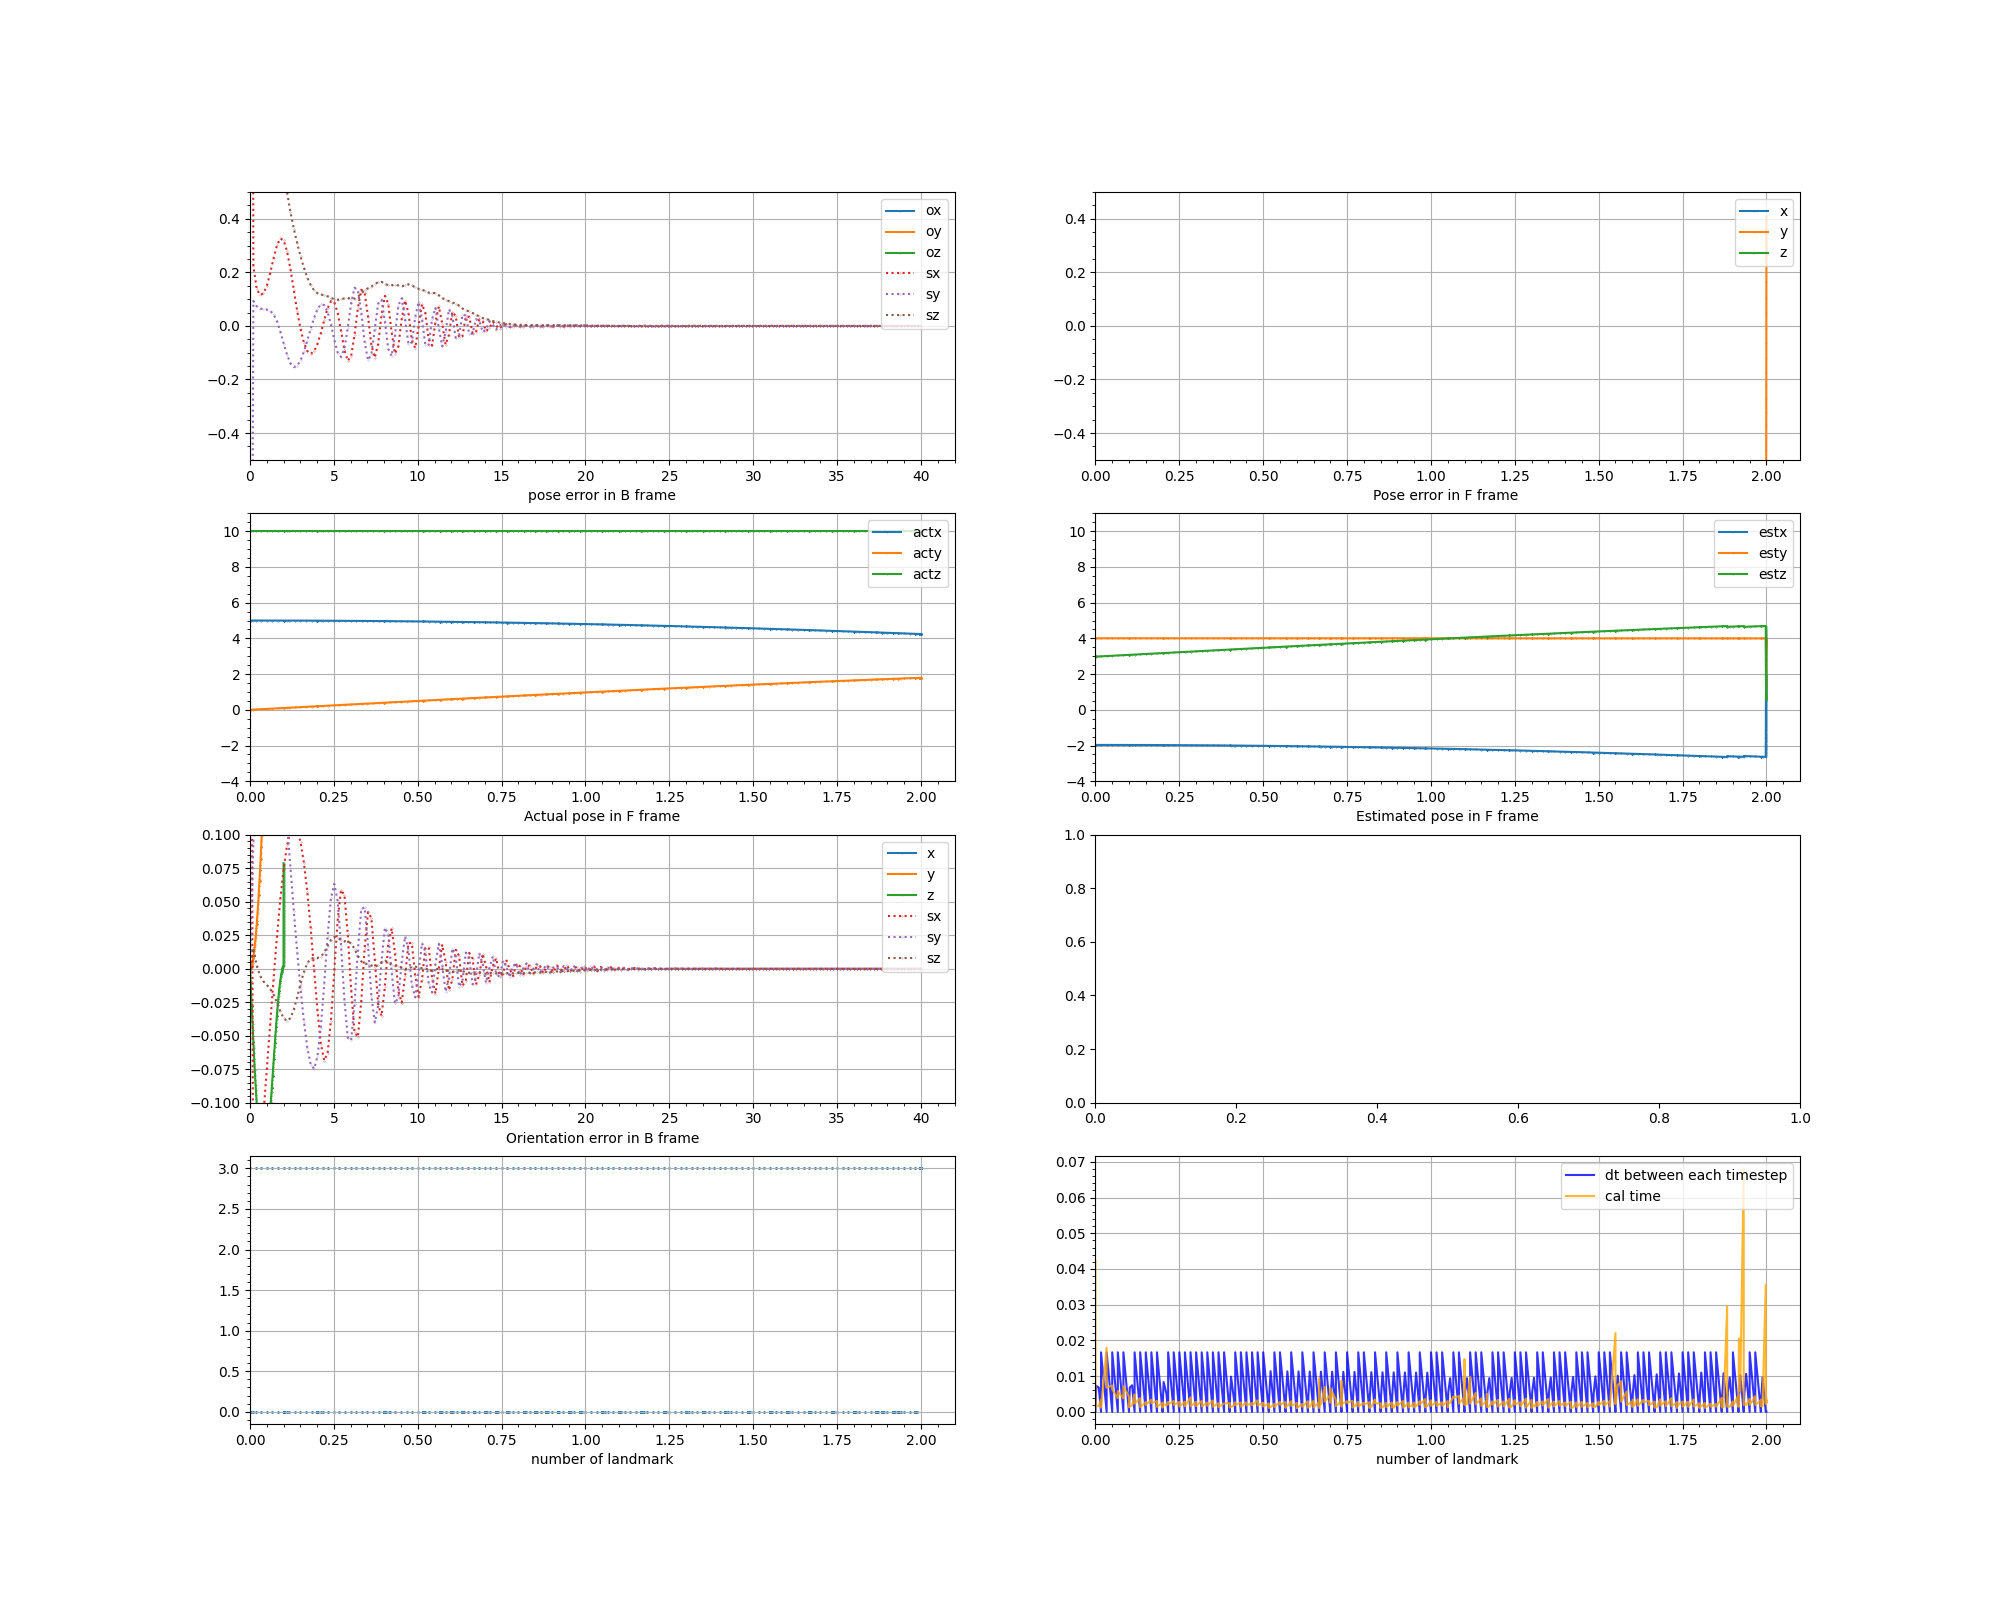

In [5]:
%matplotlib widget
riccati_obj.visual_plot(figsize=(20,16), bound_y=True)  

In [6]:
def objective(args): # can also set different case
    Q, R = args # argument that need to be tuned
    output = Q ** 2 + R 
    return output

from hyperopt import hp
space = (hp.lognormal('Q', 0, 1),
        hp.lognormal('R', 0, 1))

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

print(best)
print(space_eval(space, best))

100%|██████████| 100/100 [00:00<00:00, 516.29trial/s, best loss: 4.6517722765106545e-42]
{'Q': 3.814805400528699e-44, 'R': 4.6517722765106545e-42}
(3.814805400528699e-44, 4.6517722765106545e-42)
